In [27]:
# check original MPAS files
# to make sure that each has the same set of variables

from pathlib import Path
import numpy as np

import xarray as xr
import uxarray as ux

dataloc = Path("/glade/campaign/mmm/wmr/skamaroc/NSC_2023/3.75km_simulation_output_old_transport")

# 1hr files:
datafils = sorted(dataloc.glob("DYAMOND_diag_1h.3.75km.*.nc")) # note: 4.4GB per file



In [47]:
fds = xr.open_dataset(datafils[0])

sds = xr.open_dataset(datafils[1])

tds = xr.open_dataset(datafils[2])

In [50]:
datafils

[PosixPath('/glade/campaign/mmm/wmr/skamaroc/NSC_2023/3.75km_simulation_output_old_transport/DYAMOND_diag_1h.3.75km.2020-01-20_00.00.00.nc'),
 PosixPath('/glade/campaign/mmm/wmr/skamaroc/NSC_2023/3.75km_simulation_output_old_transport/DYAMOND_diag_1h.3.75km.2020-01-20_01.00.00.nc'),
 PosixPath('/glade/campaign/mmm/wmr/skamaroc/NSC_2023/3.75km_simulation_output_old_transport/DYAMOND_diag_1h.3.75km.2020-01-20_02.00.00.nc'),
 PosixPath('/glade/campaign/mmm/wmr/skamaroc/NSC_2023/3.75km_simulation_output_old_transport/DYAMOND_diag_1h.3.75km.2020-01-20_03.00.00.nc'),
 PosixPath('/glade/campaign/mmm/wmr/skamaroc/NSC_2023/3.75km_simulation_output_old_transport/DYAMOND_diag_1h.3.75km.2020-01-20_04.00.00.nc'),
 PosixPath('/glade/campaign/mmm/wmr/skamaroc/NSC_2023/3.75km_simulation_output_old_transport/DYAMOND_diag_1h.3.75km.2020-01-20_05.00.00.nc'),
 PosixPath('/glade/campaign/mmm/wmr/skamaroc/NSC_2023/3.75km_simulation_output_old_transport/DYAMOND_diag_1h.3.75km.2020-01-20_06.00.00.nc'),
 Posix

In [49]:
tds['xtime'].values

time_str = tds.xtime.astype(str).values.astype('U').ravel()
# Remove extra whitespace and handle empty strings
time_str = [x.strip() for x in time_str]
time_str = [x.replace("_", " ") for x in time_str]
time_str

['2020-01-20 02:00:00']

In [29]:
# wez = xr.open_dataset("/glade/derecho/scratch/digital-earths-hackathon/mpas_DYAMOND3/v4/mpas_to_healpix_weights_order10_wrap4ez2.nc")

# prime meridian buffer pushed to 45
# wez = xr.open_dataset("/glade/derecho/scratch/digital-earths-hackathon/mpas_DYAMOND3/v4/mpas_to_healpix_weights_order10_wrap4ez3.nc")

# lon buffer pushed to 45
wez = xr.open_dataset("/glade/derecho/scratch/digital-earths-hackathon/mpas_DYAMOND3/v4/mpas_to_healpix_weights_order10_wrap4ez4.nc")


In [30]:

# vset = set(fds.data_vars)

# for fil in datafils:
#     tds = xr.open_dataset(fil)
#     if vset - set(tds.data_vars):
#         print(f'file {fil.name} fails')

# sds.data_vars

CPU times: user 818 ms, sys: 467 ms, total: 1.28 s
Wall time: 2.34 s


<Figure size 640x480 with 0 Axes>

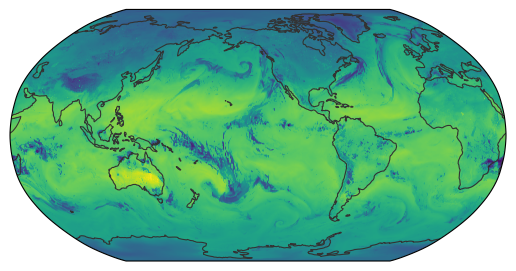

In [31]:
%%time
import dask.array as da
import easygems.healpix as egh


eweights = wez

data_to_show = sds['lwupt'].isel(Time=0)

### Rewrite from Jill Zhang
def custom_indexing(ds_var, src_idx, weights, valid):
    # Perform the advanced indexing in a NumPy context
    return np.where(valid, (ds_var[src_idx] * weights).sum(axis=-1), np.nan)


### Fast way from Jill Zhang

valid = eweights["valid"]
src_idx = eweights["src_idx"]
weights = eweights["weights"]
 
# Use map_blocks to apply the function on Dask chunks
rewrite = da.map_blocks(
    custom_indexing,
    data_to_show, src_idx, weights, valid,
    dtype=float  # Specify output dtype
)
egh.healpix_show(rewrite.compute())

In [32]:
np.sum(np.isnan(rewrite.compute()))

np.int64(0)

In [33]:
rwc = rewrite.compute()
rwc.shape

(12582912,)

<Figure size 640x480 with 0 Axes>

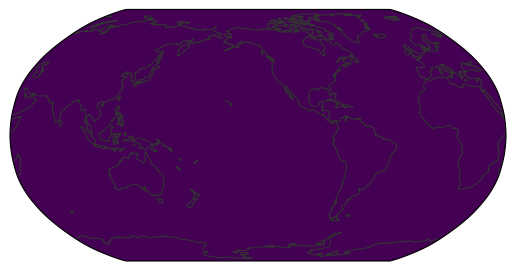

In [34]:
egh.healpix_show(wez['valid'])

In [35]:
def get_mpas_lonlat(ds, lonname, latname, degrees=True, negative=True, verbose=False, wraparound=True):
    '''Get latitude and longitude from MPAS "static" file,
       convert to degrees (default),
       convert to [-180, 180] convention (default)

    ds : xr.Dataset
        data set that needs to have lat and lon values
    latname : str
        name of the latitude variable
    lonname : str
        name of the longitude variable
    degrees : bool
        if true, convert to degrees (ASSUMES RADIANS)
    negative : bool
        if true, convert to -180 format if needed
        if false, convert to 360 format if needed
        Assumes unit is degrees, and the conversion is based on minimum longitude value being < 0 or maximum > 180
        Does not "roll" the coordinate (i.e. change the order of the longitudes)
    verbose : bool
        if true print stuff
    '''
    lonrad = ds[lonname]
    latrad = ds[latname]
    if verbose:
        print(f"Sizes: {lonrad.shape = }, {latrad.shape = } -- Compare with {ds['nCells'].shape}")
        print(f"[initial] Lat min/max: {latrad.min().item()}, {latrad.max().item()}, Lon min/max: {lonrad.min().item()},{lonrad.max().item()}")
    
    if degrees:
        # lon and lat are in radians
        lon = np.rad2deg(lonrad)
        lat = np.rad2deg(latrad)
    else:
        lon = lonrad
        lat = latrad

    if verbose:
        print(f"[degrees] Lat min/max: {lat.min().item()}, {lat.max().item()}, Lon min/max: {lon.min().item()},{lon.max().item()}")

    if negative:
        if lon.max().item() >= 180:
            lon=(lon + 180) % 360 - 180  # [-180, 180)
    else:
        if lon.min().item() < 0:
            lon += 180
    result = (lon, lat)

    # wraparound if we need to add periodic points
    # note: this shouldn't be necessary when using
    # the updated `get_weights_to_healpix` with hstack.
    if wraparound:
        orig_size = len(lon)
        lon_wrap = xr.concat([lon, lon], dim=lon.dims[0])
        lon_wrap[orig_size:] = lon+360
        orig_size = len(lat)
        lat_wrap = xr.concat([lat, lat], dim=lat.dims[0])
        if negative:
            if lon_wrap.max().item() >= 180:
                lon_wrap=(lon_wrap + 180) % 720 - 180
        else:
            if lon.min().item() < 0:
                lon += 180
        result = (lon, lat, lon_wrap, lat_wrap)            

    if verbose:
        print(f"[final] Lat min/max: {lat.min().item()}, {lat.max().item()}, Lon min/max: {lon.min().item()},{lon.max().item()}")
    return result

In [36]:
meshloc = Path("/glade/campaign/mmm/wmr/skamaroc/NSC_2023")
meshfil = meshloc / "x1.41943042.static.nc"

ds_static = xr.open_dataset(meshfil)
lon, lat = get_mpas_lonlat(ds_static, 'lonCell', 'latCell', degrees=True, negative=False, verbose=True, wraparound=False)

Sizes: lonrad.shape = (41943042,), latrad.shape = (41943042,) -- Compare with (41943042,)


[initial] Lat min/max: -1.5707963705062866, 1.5707963705062866, Lon min/max: 0.0,6.2831854820251465
[degrees] Lat min/max: -90.0, 90.0, Lon min/max: 0.0,360.0
[final] Lat min/max: -90.0, 90.0, Lon min/max: 0.0,360.0


In [37]:
lon_periodic = np.hstack((lon-360, lon))


In [38]:
src_idx = np.arange(lon.shape[0])

big_src_idx = np.arange(lon_periodic.shape[0])

back_to_src = big_src_idx % lon.shape[0]



In [39]:
back_to_src.max()

np.int64(41943041)